# Reduce on Plateau Learning Rate Scheduler

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/contrib/reduce_on_plateau.ipynb)

In this notebook, we explore the power of {py:func}`optax.contrib.reduce_on_plateau` scheduler, that reduces the learning rate when a metric has stopped improving. We will be solving a classification task by training a simple Multilayer Perceptron (MLP) on the fashion MNIST dataset.

In [11]:
from typing import Sequence
from flax import linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from optax import contrib
from optax import tree_utils
import tensorflow as tf
import tensorflow_datasets as tfds

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on CPU


In [12]:
# @markdown The initial learning rate for the optimizer:
LEARNING_RATE = 0.01  # @param{type:"number"}
# @markdown Number of samples in each batch:
BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown Total number of epochs to train for:
N_EPOCHS = 50  # @param{type:"integer"}
# @markdown Number of epochs with no improvement after which learning rate will be reduced:
PATIENCE = 5  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 0  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}

Fashion MNIST is a dataset of 28x28 grayscale image, associated with a label from 10 classes. We now load the dataset using `tensorflow_datasets`, apply min-max normalization to the images, shuffle the data in the train set and create batches of size `BATCH_SIZE`.


In [13]:
(train_loader, test_loader), info = tfds.load(
    "fashion_mnist", split=["train", "test"], as_supervised=True, with_info=True
)

min_max_norm = lambda image, label: (tf.cast(image, tf.float32) / 255., label)
train_loader = train_loader.map(min_max_norm)
test_loader = test_loader.map(min_max_norm)

NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape

train_loader_batched = train_loader.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

The data is ready! Next let's define a model. Optax is agnostic to which (if any) neural network library is used. Here we use Flax to implement a simple MLP.

In [14]:
class MLP(nn.Module):
  """A simple multilayer perceptron model for image classification."""
  hidden_sizes: Sequence[int] = (1000, 1000)

  @nn.compact
  def __call__(self, x):
    # Flattens images in the batch.
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(features=self.hidden_sizes[0])(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.hidden_sizes[1])(x)
    x = nn.relu(x)
    x = nn.Dense(features=NUM_CLASSES)(x)
    return x

In [15]:
net = MLP()


@jax.jit
def loss_accuracy(params, data):
  """Computes loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    data: tuple of (inputs, labels).

  Returns:
    loss: float
  """
  inputs, labels = data
  logits = net.apply({"params": params}, inputs)
  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=labels
  ).mean()
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  return loss, {"accuracy": accuracy}

Next we initialize network parameters.

In [16]:
rng = jax.random.PRNGKey(0)
fake_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)
parameters = net.init({"params": rng}, fake_data)["params"]


def dataset_stats(params, data_loader):
  """Computes loss and accuracy over the dataset `data_loader`."""
  all_accuracy = []
  all_loss = []
  for batch in data_loader.as_numpy_iterator():
    batch_loss, batch_aux = loss_accuracy(params, batch)
    all_loss.append(batch_loss)
    all_accuracy.append(batch_aux["accuracy"])
  return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

Here we initialize the solver. Note that during the training process, the learning rate of the solver remains unchanged.

In [17]:
opt = optax.chain(
    optax.adam(LEARNING_RATE),
    contrib.reduce_on_plateau(
        patience=PATIENCE, cooldown=COOLDOWN, factor=FACTOR, rtol=RTOL
    ),
)
opt_state = opt.init(parameters)

In the next cell, we initialize the `contrib.reduce_on_plateau` scheduler, which reduces learning rate when a monitored metric has stopped improving. We will be using this scheduler to scale the updates, produced by the regular Adam optimizer.

Additionally, the code initializes the state for the scheduler by calling `transform.init(parameters)`. Note that the initial learning rate for the scheduler is not explicitly set, so it will default to 1.0, which means there will be no scaling of the learning rate initially.

In [18]:
# transform = contrib.reduce_on_plateau(
#     patience=PATIENCE, cooldown=COOLDOWN, factor=FACTOR, rtol=RTOL)

# # Creates initial state for `contrib.reduce_on_plateau` transformation.
# transform_state = transform.init(parameters)
# transform_state

The next cell trains the model for `N_EPOCHS` epochs. At the end of each epoch, the learning rate scaling value is updated based on the loss computed on the test set.

In [19]:
@jax.jit
def train_step(params, opt_state, batch):
  """Performs a one step update."""
  (value, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
      params, batch
  )
  updates, opt_state = opt.update(grad, opt_state, params, value=value)
  params = optax.apply_updates(params, updates)
  return params, opt_state, value, aux


train_accuracy = []
train_losses = []

# Computes test set accuracy at initialization.
test_stats = dataset_stats(parameters, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_losses = [test_stats["loss"]]

lr_scale_history = []
for epoch in range(N_EPOCHS):
  train_accuracy_epoch = []
  train_losses_epoch = []

  for train_batch in train_loader_batched.as_numpy_iterator():
    parameters, opt_state, train_loss, train_aux = train_step(
        parameters, opt_state, train_batch
    )
    train_accuracy_epoch.append(train_aux["accuracy"])
    train_losses_epoch.append(train_loss)
    lr_scale = tree_utils.tree_get(opt_state, "lr")
    lr_scale_history.append(lr_scale)

  test_stats = dataset_stats(parameters, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])
  # fetch the scaling factor from the reduce_on_plateau transform
  mean_train_accuracy = np.mean(train_accuracy_epoch)
  print(f"Epoch {epoch + 1}/{N_EPOCHS}, mean train accuracy: {mean_train_accuracy}")
  train_accuracy.append(mean_train_accuracy)
  train_losses.append(np.mean(train_losses_epoch))

Epoch 1/50, mean train accuracy: 0.7835536599159241
Epoch 2/50, mean train accuracy: 0.8024672865867615
Epoch 3/50, mean train accuracy: 0.8024505972862244
Epoch 4/50, mean train accuracy: 0.8025173544883728
Epoch 5/50, mean train accuracy: 0.8025173544883728
Epoch 6/50, mean train accuracy: 0.802550733089447
Epoch 7/50, mean train accuracy: 0.8023838400840759
Epoch 8/50, mean train accuracy: 0.8024172186851501
Epoch 9/50, mean train accuracy: 0.8024172186851501
Epoch 10/50, mean train accuracy: 0.8024672865867615
Epoch 11/50, mean train accuracy: 0.8023838400840759
Epoch 12/50, mean train accuracy: 0.8024339079856873
Epoch 13/50, mean train accuracy: 0.8024172186851501
Epoch 14/50, mean train accuracy: 0.8024505972862244
Epoch 15/50, mean train accuracy: 0.8023838400840759
Epoch 16/50, mean train accuracy: 0.8024505972862244
Epoch 17/50, mean train accuracy: 0.8025006651878357
Epoch 18/50, mean train accuracy: 0.8024839758872986
Epoch 19/50, mean train accuracy: 0.8023838400840759
Epo

/var/folders/1l/n8cn3h6s7v122g4rtd0kv80r00klsn/T/ipykernel_5419/153033803.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


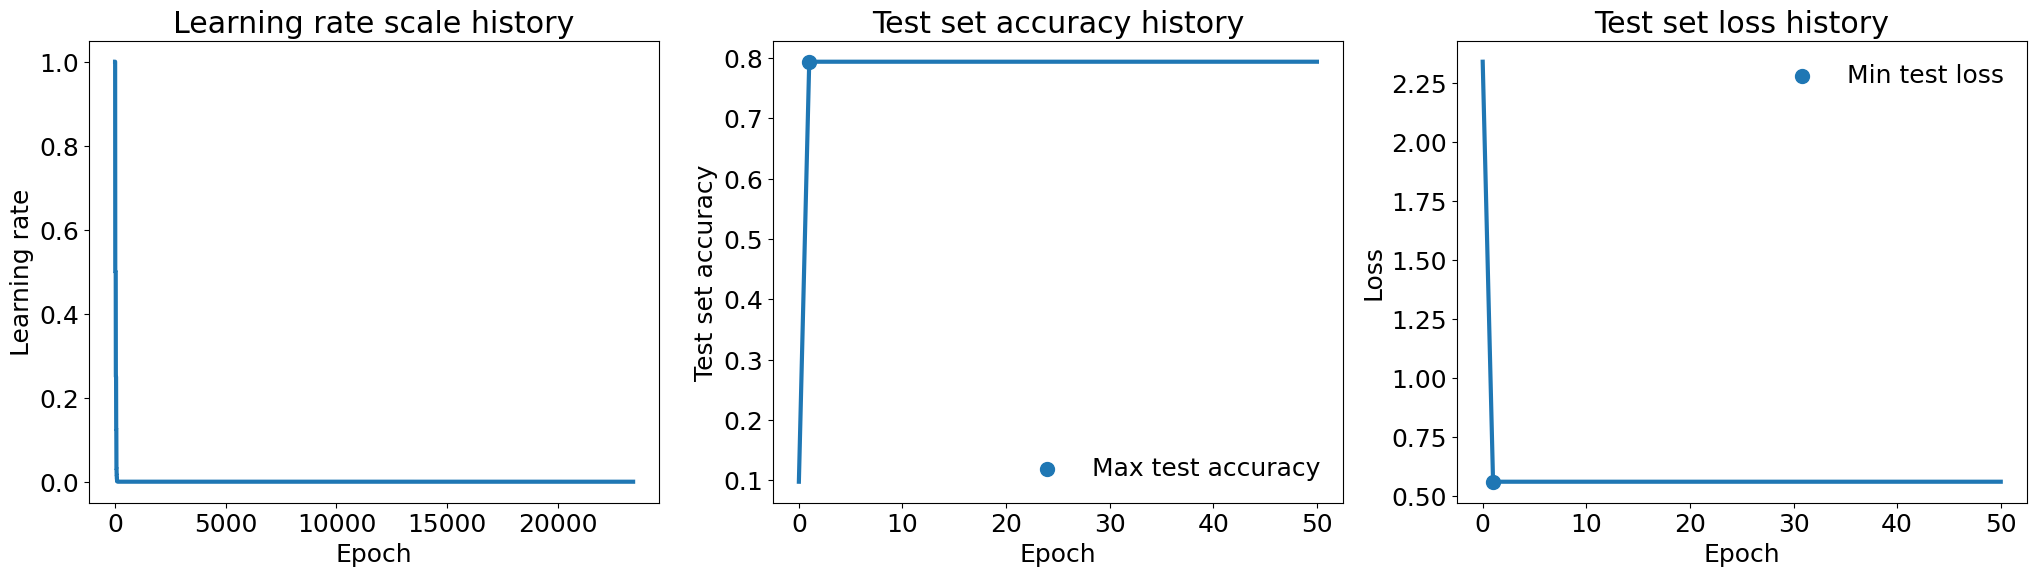

In [20]:
plt.rcParams["figure.figsize"] = (25, 6)
plt.rcParams.update({"font.size": 18})

fig, axs = plt.subplots(ncols=3)

axs[0].plot(lr_scale_history, lw=3)
axs[0].set_title("Learning rate scale history")
axs[0].set_ylabel("Learning rate")
axs[0].set_xlabel("Epoch")


axs[1].plot(test_accuracy, lw=3)
axs[1].scatter(
    jnp.argmax(jnp.array(test_accuracy)),
    max(test_accuracy),
    label="Max test accuracy",
    s=100,
)
axs[1].set_title("Test set accuracy history")
axs[1].set_ylabel("Test set accuracy")
axs[1].legend(frameon=False)
axs[1].set_xlabel("Epoch")

axs[2].plot(test_losses, lw=3)
axs[2].scatter(
    jnp.argmin(jnp.array(test_losses)),
    min(test_losses),
    label="Min test loss",
    s=100,
)
axs[2].set_title("Test set loss history")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
axs[2].legend(frameon=False)

fig.show()